In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [52]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import imutils
import cv2
from os import listdir
import pickle

ModuleNotFoundError: No module named 'imutils'

In [3]:
IMAGE_SIZE = [224, 224]

train_path = r"C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
valid_path = r"C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid"

In [4]:
import os
diseases = os.listdir(train_path)
print(diseases)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [5]:
print("Total disease classes are: {}",len(diseases))

Total disease classes are: {} 38


In [6]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':1
        NumberOfDiseases += 1

UNIQUE PLANTS IN THE DATASET

In [7]:
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']


In [8]:
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


NO OF CROP DISEASES CONSIDERED IN THE DATASET

In [9]:
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


In [10]:
import pandas as pd
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_path + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___healthy,1826
Cherry_(including_sour)___Powdery_mildew,1683
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___healthy,1859


Text(0.5, 1.0, 'Images per each class of plant disease')

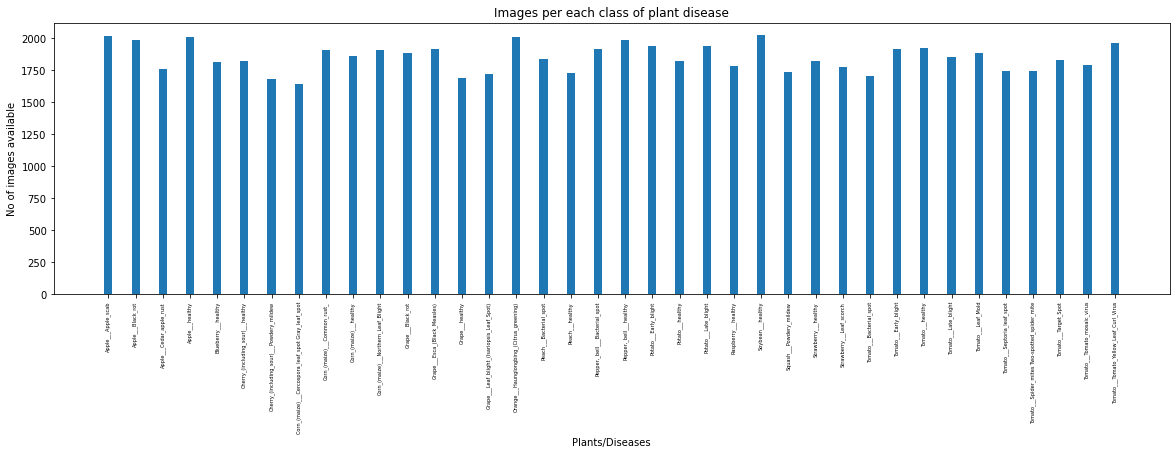

In [11]:
# plotting number of images available for each disease
import matplotlib.pyplot as plt
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [12]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


In [13]:
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms 

In [14]:
train = ImageFolder(train_path, transform=transforms.ToTensor())
valid = ImageFolder(valid_path, transform=transforms.ToTensor()) 

SHOW IMAGES

In [15]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [16]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


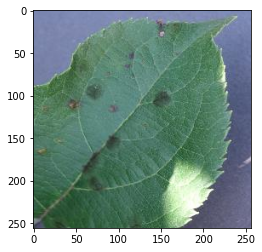

In [17]:
show_image(*train[5])

Label :Pepper,_bell___Bacterial_spot(18)


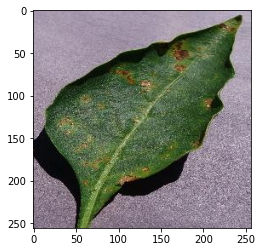

In [18]:
show_image(*train[34569])

In [19]:
IMAGE_SIZE = [224, 224]

In [20]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [21]:
for layer in inception.layers:
    layer.trainable = False

In [22]:
folders = glob(r'C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\*')



In [23]:
x = Flatten()(inception.output)

In [24]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [26]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
training_set = train_datagen.flow_from_directory(r'C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 70295 images belonging to 38 classes.


In [29]:
test_set = test_datagen.flow_from_directory(r'C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 17572 images belonging to 38 classes.


In [30]:
import PIL
import scipy
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)  

Epoch 1/5
2197/2197 [==============================] - 9725s 4s/step - loss: 3.6982 - accuracy: 0.7837 - val_loss: 4.1630 - val_accuracy: 0.8346
Epoch 2/5
2197/2197 [==============================] - 37788s 17s/step - loss: 2.9453 - accuracy: 0.8748 - val_loss: 4.0653 - val_accuracy: 0.8603
Epoch 3/5
2197/2197 [==============================] - 7191s 3s/step - loss: 2.8889 - accuracy: 0.8948 - val_loss: 3.0760 - val_accuracy: 0.8974
Epoch 4/5
2197/2197 [==============================] - 32561s 15s/step - loss: 2.6459 - accuracy: 0.9102 - val_loss: 3.4946 - val_accuracy: 0.8970
Epoch 5/5
2197/2197 [==============================] - 8849s 4s/step - loss: 2.5386 - accuracy: 0.9182 - val_loss: 3.0289 - val_accuracy: 0.9125


In [31]:


from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [43]:
test_images = sorted(os.listdir(test_dir + '/test')) 
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [60]:

ht=224
wd=224
className = []

# Give the trained dataset path here it will just collect the labels 
# or directly create a list with class names
pathh = r"C:\Users\GUNASAGAR\Downloads\cropdis\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
classNames = os.listdir(pathh)
totClass = len(classNames)
print(classNames)
print(totClass)

mdl = r"C:\Users\GUNASAGAR\AppData\Local\Programs\Python\Python310\Scripts\model_inception.h5"

# Testing image path 
im = r"C:\Users\GUNASAGAR\Downloads\cropdis\test\test\AppleCedaRust1"

image = cv2.imread(im)
orig = image.copy()

# pre-process the image for classification
try:
    image = cv2.resize(image, (ht, wd))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
except Exception as e:
    print("Error Occured : ",e)
    


# load the trained convolutional neural network
print("[INFO] loading network...")
model = load_model(mdl)

 
( one,two, three,four,five,six,seven, eight,nine,ten,eleven,twelve,thirteen,fourteen,fiftheen,sixtheen,seventeen,eighteen,nineteen,twenty,twentyone,twentytwo,twentythree,twentyfour,twentyfive,twentysix,twentyseven,twentyeight,twentynine,thirty,thirtyone,thirtytwo,thirtythree,thirtyfour,thirtyfive,thirtysix,thirtyseven,thirtyeight) = model.predict(image)[0]
prob = [zero, one,two, three,four,five,six,seven, eight,nine,ten,eleven,twelve,thirteen,fourteen,fiftheen,sixtheen,seventeen,eighteen,nineteen,twenty,twentyone,twentytwo,twentythree,twentyfour,twentyfive,twentysix,twentyseven,twentyeight,twentynine,thirty,thirtyone,thirtytwo,thirtythree,thirtyfour,thirtyfive,thirtysix,thirtyseven,thirtyeight] # also add here & these are not string variables

maxProb = max(prob)
maxIndex = prob.index(maxProb)
label = classNames[maxIndex]
proba = maxProb
for i in range(0,totClass):
    print(f'{classNames[i]} : {prob[i]}')
    
label = "{}: {:.2f}%".format(label, proba * 100)

# draw the label on the image
output = imutils.resize(orig, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

# show the output image
cv2.imshow("Output", output)
cv2.waitKey(0)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>